## inference in simple model using synthetic data
population size 10^4 (relatively small population)

(to be compared with analogous notebook with population 10^8)

In [1]:
%env OMP_NUM_THREADS=1

env: OMP_NUM_THREADS=1


In [2]:
%matplotlib inline
import numpy as np
import os
import pickle
import pprint
import time

import pyross
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#from matplotlib import rc; rc('text', usetex=True)

import synth_fns

(cell 3 was removed to hide local file info)
### main settings

In [4]:
## for dataFiles : needs a fresh value in every notebooke
fileRoot = 'dataSynthInfTest-pop1e4'

## total population
popN = 1e4

## tau-leaping param, take this negative to force gillespie
## or set a small value for high-accuracy tau-leap (eg 1e-4 or 1e-5)
leapEps = -1

## do we use small tolerances for the likelihood computations? (use False for debug etc)
isHighAccuracy = True

# absolute tolerance for logp for MAP 
inf_atol = 0.1

## prior mean of beta, divided by true value (set to 1.0 for the simplest case)
betaPriorOffset = 1.0
betaPriorLogNorm = False

## mcmc
mcSamples = 8000
nProcMCMC = 2 # None ## take None to use default but large numbers are not efficient in this example

### model

In [5]:
model_dict = synth_fns.get_model(popN)

model_spec = model_dict['mod']
contactMatrix = model_dict['CM']
parameters_true = model_dict['params']
cohortsM = model_dict['cohortsM']
Ni = model_dict['cohortsPop']

trajSeed = 18
infSeed = 21

#### more settings

In [6]:
## total trajectory time (bare units)
Tf_bare = 20
## total inf time
Tf_inf_bare = 5

## inference period starts when the total deaths reach this amount (as a fraction)
fracDeaths = 2e-3 # int(N*200/1e5)


In [7]:
## hack to get higher-frequency data
## how many data points per "timestep" (in original units)
fineData = 4

## this assumes that all parameters are rates !!
for key in parameters_true:
    #print(key,parameters_true[key])
    parameters_true[key] /= fineData

Tf = Tf_bare * fineData;  
Nf = Tf+1

Tf_inference = Tf_inf_bare * fineData
Nf_inference = Tf_inference+1

### plotting helper functions

In [8]:
def plotTraj(M,data_array,Nf_start,Tf_inference,fineData):
    fig = plt.figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
    #plt.rc('text', usetex=True)
    plt.rc('font', family='serif', size=12)
    t = np.linspace(0, Tf/fineData, Nf)

    # plt.plot(t, np.sum(data_array[:, :M], axis=1), '-o', label='S', lw=4)
    plt.plot(t, np.sum(data_array[:, M:2*M], axis=1), '-o', label='Exposed', lw=2)
    plt.plot(t, np.sum(data_array[:, 2*M:3*M], axis=1), '-o', label='Infected', lw=2)
    plt.plot(t, np.sum(data_array[:, 3*M:4*M], axis=1), '-o', label='Deaths', lw=2)
    #plt.plot(t, N-np.sum(data_array[:, 0:4*M], axis=1), '-o', label='Rec', lw=2)

    plt.axvspan(Nf_start/fineData, (Nf_start+Tf_inference)/fineData,alpha=0.3, color='dodgerblue')
    plt.legend()
    plt.show()

    fig,axs = plt.subplots(1,2, figsize=(12, 5), dpi=80, facecolor='w', edgecolor='k')
    ax = axs[0]
    ax.plot(t[1:],np.diff(np.sum(data_array[:, 3*M:4*M], axis=1)),'o-',label='death increments', lw=1)
    ax.legend(loc='upper right') ; # plt.show()

    ax = axs[1]
    ax.plot(t,np.sum(data_array[:, 3*M:4*M], axis=1),'o-',label='deaths',ms=3)
    ax.legend() ; 

    plt.show()


def plotMAP(res,data_array,M,N,estimator,Nf_start,Tf_inference,fineData):
    print('**beta(bare units)',res['params_dict']['beta']*fineData)
    print('**logLik',res['log_likelihood'],'true was',logpTrue)
    print('\n')
    print(res)

    fig,axs = plt.subplots(1,3, figsize=(15, 7), dpi=80, facecolor='w', edgecolor='k')
    plt.subplots_adjust(wspace=0.3)
    #plt.rc('text', usetex=True)
    plt.rc('font', family='serif', size=12)
    t = np.linspace(0, Tf/fineData, Nf)

    ax = axs[0]

    #plt.plot(t, np.sum(data_array[:, :M], axis=1), '-o', label='S', lw=4)
    ax.plot(t, np.sum(data_array[:, M:2*M], axis=1), 'o', label='Exposed', lw=2)
    ax.plot(t, np.sum(data_array[:, 2*M:3*M], axis=1), 'o', label='Infected', lw=2)
    ax.plot(t, np.sum(data_array[:, 3*M:4*M], axis=1), 'o', label='Deaths', lw=2)
    #plt.plot(t, N-np.sum(data_array[:, 0:4*M], axis=1), '-o', label='Rec', lw=2)

    tt = np.linspace(Nf_start, Tf, Nf-Nf_start,)/fineData
    xm = estimator.integrate(res['x0'], Nf_start, Tf, Nf-Nf_start, dense_output=False)
    #plt.plot(tt, np.sum(xm[:, :M], axis=1), '-x', label='S-MAP', lw=2, ms=3)
    ax.plot(tt, np.sum(xm[:, M:2*M], axis=1), '-x', color='C0',label='E-MAP', lw=2, ms=3)
    ax.plot(tt, np.sum(xm[:, 2*M:3*M], axis=1), '-x', color='C1',label='I-MAP', lw=2, ms=3)
    ax.plot(tt, np.sum(xm[:, 3*M:4*M], axis=1), '-x', color='C2',label='D-MAP', lw=2, ms=3)
    #plt.plot(tt, N-np.sum(xm[:, :4*M], axis=1), '-o', label='R-MAP', lw=2)

    ax.axvspan(Nf_start/fineData, (Nf_start+Tf_inference)/fineData,alpha=0.3, color='dodgerblue')
    ax.legend()

    ax = axs[1]
    ax.plot(t[1:], np.diff(np.sum(data_array[:, 3*M:4*M], axis=1)), '-o', label='death incs', lw=2)
    ax.plot(tt[1:], np.diff(np.sum(xm[:, 3*M:4*M], axis=1)), '-x', label='MAP', lw=2, ms=3)
    ax.axvspan(Nf_start/fineData, (Nf_start+Tf_inference)/fineData,alpha=0.3, color='dodgerblue')
    ax.legend()

    ax = axs[2]

    ax.plot(t, np.sum(data_array[:, :M], axis=1), '-o', label='Sus', lw=1.5, ms=3)
    #plt.plot(t, np.sum(data_array[:, M:2*M], axis=1), '-o', label='Exposed', lw=2)
    #plt.plot(t, np.sum(data_array[:, 2*M:3*M], axis=1), '-o', label='Infected', lw=2)
    #plt.plot(t, np.sum(data_array[:, 3*M:4*M], axis=1), '-o', label='Deaths', lw=2)
    ax.plot(t, N-np.sum(data_array[:, 0:4*M], axis=1), '-o', label='Rec', lw=1.5, ms=3)

    #infResult = res
    tt = np.linspace(Nf_start, Tf, Nf-Nf_start,)/fineData
    xm = estimator.integrate(res['x0'], Nf_start, Tf, Nf-Nf_start, dense_output=False)
    ax.plot(tt, np.sum(xm[:, :M], axis=1), '-x', label='S-MAP', lw=2, ms=3)
    #plt.plot(tt, np.sum(xm[:, M:2*M], axis=1), '-x', label='E-MAP', lw=2, ms=3)
    #plt.plot(tt, np.sum(xm[:, 2*M:3*M], axis=1), '-x', label='I-MAP', lw=2, ms=3)
    #plt.plot(tt, np.sum(xm[:, 3*M:4*M], axis=1), '-x', label='D-MAP', lw=2, ms=3)
    ax.plot(tt, N-np.sum(xm[:, :4*M], axis=1), '-x', label='R-MAP', lw=1.5, ms=3)

    ax.axvspan(Nf_start/fineData, (Nf_start+Tf_inference)/fineData,alpha=0.3, color='dodgerblue')
    ax.legend()
    plt.show()
    

    
def plotMCtrace(selected_dims, sampler, numTrace=None):
    # Plot the trace for these dimensions:
    plot_dim = len(selected_dims)
    plt.rcParams.update({'font.size': 14})
    fig, axes = plt.subplots(plot_dim, figsize=(12, plot_dim), sharex=True)
    samples = sampler.get_chain()
    if numTrace == None : numTrace = np.shape(samples)[1]  ## corrected index
    for ii,dd in enumerate(selected_dims):
        ax = axes[ii]
        ax.plot(samples[:, :numTrace , dd], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
    axes[-1].set_xlabel("step number");
    plt.show(fig)
    plt.close()

def plotPosteriors(estimator,obsData, fltrDeath, Tf_inference,param_priors, init_priors,contactMatrix,
                   infResult,parameters_true,trueInit,rangeParam=0.5) :
    ## used for prior pdfs
    (likFun,priFun,dimFlat) = pyross.evidence.latent_get_parameters(estimator,
                                        obsData, fltrDeath, Tf_inference,
                                        param_priors, init_priors,                                   
                                        contactMatrix,
                                        #intervention_fun=interventionFn,
                                        tangent=False,
                                      )
    xVals = np.linspace(parameters_true['beta']*(1-rangeParam),parameters_true['beta']*(1+rangeParam),100)

    betas = [ rr['params_dict']['beta'] for rr in result_mcmc ]
    plt.hist(betas,density=True,color='lightblue',label='posterior')
    yVal=2
    plt.plot([infResult['params_dict']['beta']],[yVal],'bs',label='MAP',ms=10)
    plt.plot([parameters_true['beta']],[yVal],'ro',label='true',ms=10)


    ## this is a bit complicated, it just finds the prior for beta from the infResult
    var='beta'
    jj = infResult['param_keys'].index(var)
    xInd = infResult['param_guess_range'][jj]
    #print(jj,xInd)
    pVals = []
    for xx in xVals :
        flatP = np.zeros( dimFlat )
        flatP[xInd] = xx
        pdfAll = np.exp( priFun.logpdf(flatP) )
        pVals.append( pdfAll[xInd] )
    plt.plot(xVals,pVals,color='darkgreen',label='prior')


    plt.xlabel(var)
    plt.ylabel('pdf')
    plt.legend()

    labs=['init S','init E','init I']
    nPanel=3
    fig,axs = plt.subplots(1,nPanel,figsize=(14,4))
    for ii in range(nPanel) :   
        ax = axs[ii]
        yVal=1.0/popN
        xs = [ rr['x0'][ii] for rr in result_mcmc ]
        ax.hist(xs,color='lightblue',density=True)
        ax.plot([infResult['x0'][ii]],yVal,'bs',label='true')
        ax.plot([trueInit[ii]],yVal,'ro',label='true')


        ## this is a bit complicated, it just finds the prior for beta from the infResult
        ## axis ranges
        xMin = np.min(xs)*0.8
        xMax = np.max(xs)*1.2
        xVals = np.linspace(xMin,xMax,100)

        ## this ID is a negative number because the init params are the end of the 'flat' param array
        paramID = ii-nPanel 
        pVals = []
        for xx in xVals :
            flatP = np.zeros( dimFlat )
            flatP[paramID] = xx
            pdfAll = np.exp( priFun.logpdf(flatP) )
            pVals.append( pdfAll[paramID] )
        ax.plot(xVals,pVals,color='darkgreen',label='prior')

        #plt.xlabel(var)
        ax.set_xlabel(labs[ii])
        ax.set_ylabel('pdf')
        ax.yaxis.set_ticklabels([])

    plt.show()


### synthetic data

In [9]:
ticTime = time.time()
syntheticData = synth_fns.make_stochastic_traj(Tf,Nf,trajSeed,model_dict,leapEps)
tocTime = time.time() - ticTime
print('traj generation time',tocTime,'secs')

np.save(fileRoot+'-stochTraj.npy',syntheticData)

Nf_start = synth_fns.get_start_time(syntheticData, popN, fracDeaths)
print('inf starts at timePoint',Nf_start)

{'beta': 0.035, 'gE': 0.35000000000000003, 'gR': 0.245, 'gD': 0.005, 'seed': 18}
traj generation time 0.5362493991851807 secs
inf starts at timePoint 26


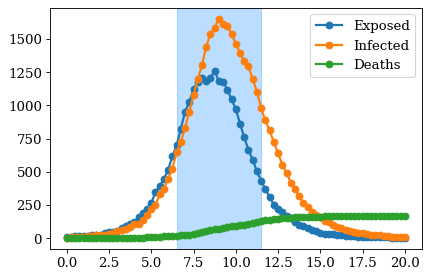

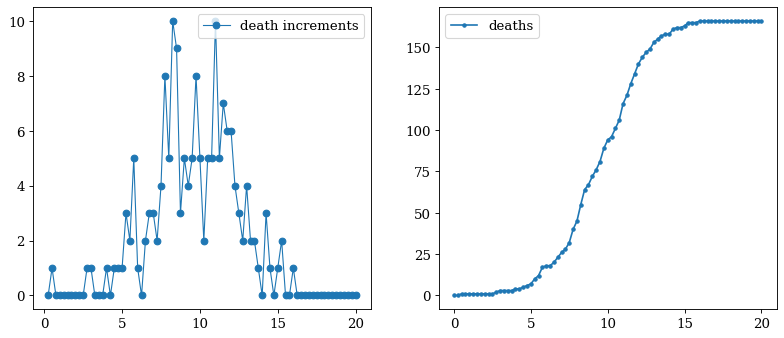

In [10]:
plotTraj(cohortsM,syntheticData,Nf_start,Tf_inference,fineData)

### basic inference (estimator) setup
(including computation of likelihood for the true parameters)

In [11]:
[estimator,fltrDeath,obsData,trueInit] = synth_fns.get_estimator(isHighAccuracy,model_dict,syntheticData, popN, Nf_start, Nf_inference,)

## compute log-likelihood of true params
logpTrue = -estimator.minus_logp_red(parameters_true, trueInit, obsData, fltrDeath, Tf_inference, 
                                     contactMatrix, tangent=False)
print('**logLikTrue',logpTrue,'\n')

print('death data\n',obsData,'length',np.size(obsData),Nf_inference)

setting high-accuracy for likelihood
**logLikTrue -47.11436352758756 

death data
 [[ 20.]
 [ 23.]
 [ 26.]
 [ 28.]
 [ 32.]
 [ 40.]
 [ 45.]
 [ 55.]
 [ 64.]
 [ 67.]
 [ 72.]
 [ 76.]
 [ 81.]
 [ 89.]
 [ 94.]
 [ 96.]
 [101.]
 [106.]
 [116.]
 [121.]
 [128.]] length 21 21


### priors

In [12]:
[param_priors,init_priors] = synth_fns.get_priors(model_dict,betaPriorOffset,betaPriorLogNorm,fracDeaths,estimator)
print('Prior Params:',param_priors)
print('Prior Inits:')
pprint.pprint(init_priors)
print('trueBeta',parameters_true['beta'])
print('trueInit',trueInit)

Prior Params: {'beta': {'mean': 0.035, 'std': 0.0175, 'bounds': [0.0001, 0.17500000000000002], 'prior_fun': 'truncnorm'}}
Prior Inits:
{'independent': {'bounds': [[720.0, 10000.0],
                            [101.00251257867602, 10100.251257867601],
                            [78.99748742132398, 7899.748742132398]],
                 'fltr': array([ True,  True,  True, False]),
                 'mean': array([7200.        , 1010.02512579,  789.97487421]),
                 'prior_fun': 'truncnorm',
                 'std': array([336.67504193, 336.67504193, 263.32495807])}}
trueBeta 0.035
trueInit [7801.  699.  651.   20.]


### inference (MAP)

In [13]:
infResult = synth_fns.do_inf(estimator, obsData, fltrDeath, syntheticData, 
                             popN, Tf_inference, infSeed, param_priors,init_priors, model_dict, inf_atol)

Starting global minimisation ...
(32_w,64)-aCMA-ES (mu_w=17.6,w_1=11%) in dimension 4 (seed=21, Mon May  3 22:14:49 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     64 6.321464930546847e+01 1.0e+00 1.07e+00  1e-02  3e+02 0:02.9
    2    128 6.315091300122263e+01 1.4e+00 9.81e-01  9e-03  3e+02 0:05.8
    3    192 6.288289473534563e+01 1.8e+00 8.94e-01  6e-03  2e+02 0:08.7
    5    320 6.252184912977002e+01 3.2e+00 8.02e-01  3e-03  1e+02 0:14.3
    7    448 6.250467703447582e+01 4.0e+00 6.66e-01  1e-03  6e+01 0:20.1
    9    576 6.247537059591070e+01 4.3e+00 5.73e-01  7e-04  3e+01 0:26.5
   11    704 6.247095403739424e+01 5.1e+00 4.59e-01  3e-04  1e+01 0:32.7
   14    896 6.247020438329272e+01 4.3e+00 3.64e-01  9e-05  5e+00 0:42.0
   15    960 6.247025390431008e+01 4.6e+00 3.49e-01  8e-05  3e+00 0:45.2
Optimal value (global minimisation):  62.470204383292725
Starting local minimisation...
Optimal value (local minimisation):  62.47020106702568


In [14]:
#pprint.pprint(infResult)
print('MAP likelihood',infResult['log_likelihood'],'true',logpTrue)
print('MAP beta',infResult['params_dict']['beta'],'true',parameters_true['beta'])


MAP likelihood -45.1791324876427 true -47.11436352758756
MAP beta 0.029881396446140403 true 0.035


### plot MAP trajectory

**beta(bare units) 0.11952558578456161
**logLik -45.1791324876427 true was -47.11436352758756


{'params_dict': {'beta': 0.029881396446140403, 'gE': 0.35000000000000003, 'gR': 0.245, 'gD': 0.005, 'seed': 18}, 'x0': array([7237.5656946 ,  896.40863481,  562.36163514,   20.        ]), 'flat_params': array([2.98813964e-02, 7.23756569e+03, 8.96408635e+02, 5.62361635e+02]), 'log_posterior': -62.47020106702568, 'log_prior': -17.29106857938298, 'log_likelihood': -45.1791324876427, 'param_keys': ['beta'], 'param_guess_range': [0], 'is_scale_parameter': [False], 'param_length': 1, 'scaled_param_guesses': [], 'init_flags': [False, True], 'init_fltrs': [None, array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]])], 'prior': <pyross.utils_python.Prior object at 0x7ffb9265f430>}


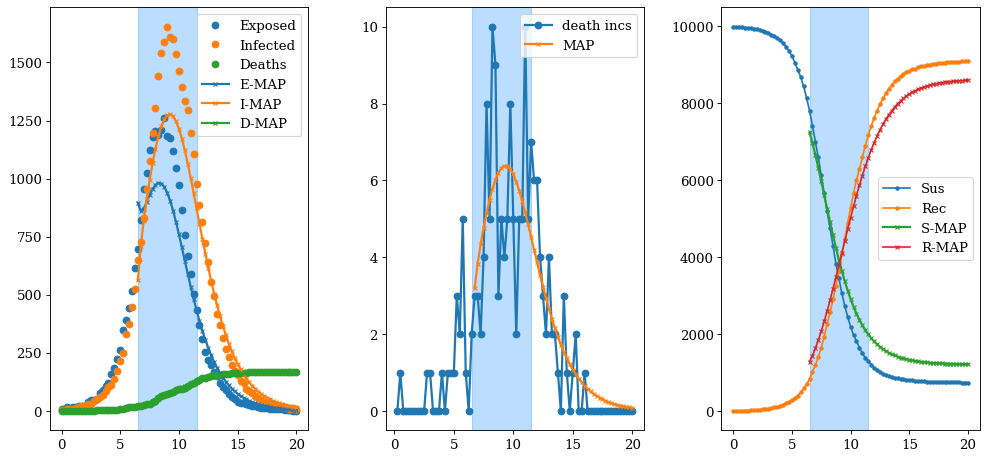

In [15]:
plotMAP(infResult,syntheticData,cohortsM,popN,estimator,Nf_start,Tf_inference,fineData)

#### slice of likelihood 
(note this is not the posterior, hence MAP is not exactly at the peak)

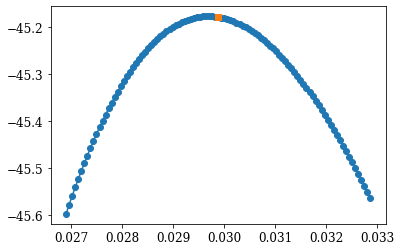

In [16]:
## range for beta (relative to MAP)
rangeParam = 0.1
[bVals,likVals] = synth_fns.sliceLikelihood(rangeParam,infResult,
                                            estimator,obsData,fltrDeath,contactMatrix,Tf_inference)

#print('logLiks',likVals,logp)
plt.plot(bVals , likVals, 'o-')
plt.plot(infResult['params_dict']['beta'],infResult['log_likelihood'],'s',ms=6)
plt.show()

### MCMC

In [17]:
sampler = synth_fns.do_mcmc(mcSamples, nProcMCMC, estimator, Tf_inference, infResult, 
                            obsData, fltrDeath, param_priors, init_priors, 
                            model_dict)

est map [2.98813964e-02 7.23756569e+03 8.96408635e+02 5.62361635e+02] 4


100%|██████████| 8000/8000 [2:46:41<00:00,  1.25s/it]  


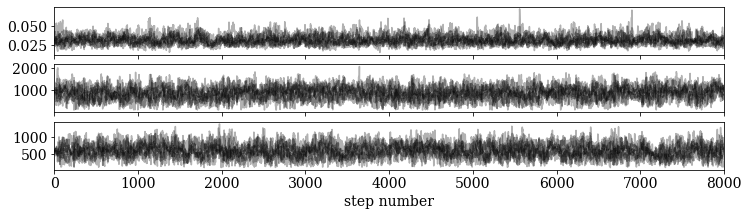

result shape (528,)
last sample
 {'params_dict': {'beta': 0.033672340702668585, 'gE': 0.35000000000000003, 'gR': 0.245, 'gD': 0.005, 'seed': 18}, 'x0': array([7225.81966035,  979.28420591,  816.77915931,   20.        ]), 'flat_params': array([3.36723407e-02, 7.22581966e+03, 9.79284206e+02, 8.16779159e+02]), 'log_posterior': -65.68520975876068, 'log_prior': -16.826716340102536, 'log_likelihood': -48.85849341865814, 'weight': 0.001893939393939394, 'param_keys': ['beta'], 'param_guess_range': [0], 'is_scale_parameter': [False], 'param_length': 1, 'scaled_param_guesses': [], 'init_flags': [False, True], 'init_fltrs': [None, array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]])], 'prior': <pyross.utils_python.Prior object at 0x7ffb92869520>}


In [18]:
plotMCtrace([0,2,3], sampler)
result_mcmc = synth_fns.load_mcmc_result(estimator, obsData, fltrDeath, sampler, param_priors, init_priors, model_dict)

print('result shape',np.shape(result_mcmc))
print('last sample\n',result_mcmc[-1])

#### save the result

In [19]:
opFile = fileRoot + "-mcmc.pik"
print('opf',opFile)
with open(opFile, 'wb') as f: 
    pickle.dump([infResult,result_mcmc],f)

opf dataSynthInfTest-pop1e4-mcmc.pik


#### estimate MCMC autocorrelation

In [20]:
# these are the estimated autocorrelation times for the sampler
# (it likes runs ~50 times longer than this...)
pp = sampler.get_log_prob()
nSampleTot = np.shape(pp)[0]
print('correl',sampler.get_autocorr_time(discard=int(nSampleTot/3)))
print('nSampleTot',nSampleTot)

correl [49.55674251 59.18032585 55.33758422 63.65951182]
nSampleTot 8000


#### plot posterior distributions

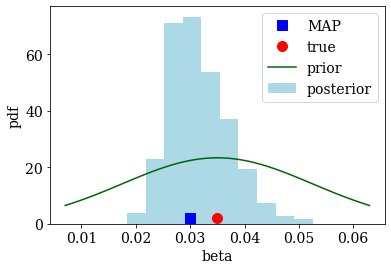

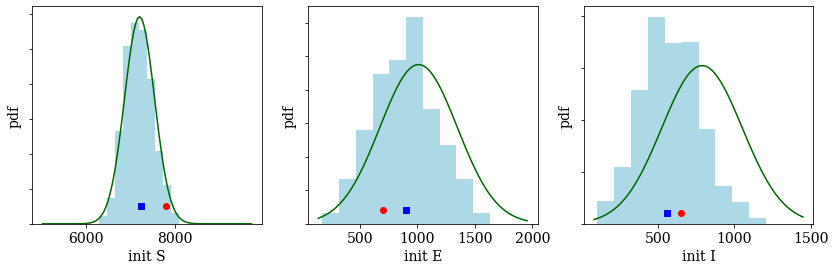

In [21]:
plotPosteriors(estimator,obsData, fltrDeath, Tf_inference,param_priors, init_priors,contactMatrix,
                   infResult,parameters_true,trueInit,rangeParam=0.8)


In [22]:
betas = [ rr['params_dict']['beta'] for rr in result_mcmc ]
postMeanBeta = np.mean(betas)
postStdBeta = np.std(betas)
postCIBeta = [ np.percentile(betas,2.5) , np.percentile(betas,97.5)]

print("beta: true {b:.4f} MAP {m:.4f}".format(b=parameters_true['beta'],m=infResult['params_dict']['beta']))
print("post: mean {m:.4f} std {s:.4f} CI95 {l:.4f} {u:.4f}".format(m=postMeanBeta,
                                                                 s=postStdBeta,
                                                                 l=postCIBeta[0],u=postCIBeta[1]))


beta: true 0.0350 MAP 0.0299
post: mean 0.0316 std 0.0055 CI95 0.0229 0.0432
